In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
result_dir = 'results'

# Opening Activity Index File

The activity and attenuation objects can be opened as such. These files are c

In [3]:
Ci_to_MBq = 37000
activity_distribution = np.fromfile(f'{result_dir}/groundtruth.actimg', dtype=np.float32)
activity_distribution = activity_distribution.reshape((12,128,128))  * Ci_to_MBq
attenuation_distribution = np.fromfile(f'{result_dir}/groundtruth.attimg', dtype=np.float32)
attenuation_distribution = attenuation_distribution.reshape((12,128,128)) 
np.sum(activity_distribution) * 0.5 * 0.5 * 4 # How many MBq injected

181.2852020263672

One can also explore the `index` file (containing integers). This file is used as input to the simulation, and uses the the table corresponding to the `activity_index_trans` of the `testPET.phg_params` file to translate this to actual activities.

In [4]:
activity_distribution_index = np.fromfile('testPET.act_index', dtype=np.int32)
activity_distribution_index = activity_distribution_index.reshape((12,128,128))

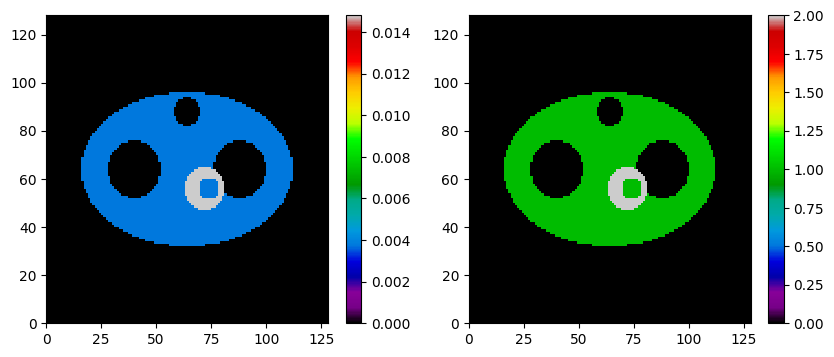

In [5]:
plt.subplots(1,2, figsize=(10,4))
plt.subplot(121)
plt.pcolormesh(activity_distribution[6], cmap='nipy_spectral')
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(activity_distribution_index[6], cmap='nipy_spectral')
plt.colorbar()

# Opening Projection File

The simulated projection data is opened as follows:

In [6]:
a = np.fromfile(f'results/sinogram2.hst', dtype=np.float32, offset=32768)

In [8]:
xs = []
for i in range(0,10):
    xs.append(np.fromfile(f'{result_dir}/sinogram{i}.hst', dtype=np.float32, offset=32768).reshape((2,3,3,128,64)))
image = np.mean(xs, axis=0)
image_primary = image[0]
image_scatter = image[1]
image_tot = image[0] + image[1]

The PET data is stored in a 5D array
* `axis=0` corresponds to primary/scatter
* `axis=1` corresponds to $z_1$ ($z$ location of photon 1)
* `axis=2` corresponds to $z_2$ ($z$ location of photon 2)
* `axis=3` corresponds to $\theta$
* `axis=4` corresponds to $r$

The primary and scatter images are obtained above

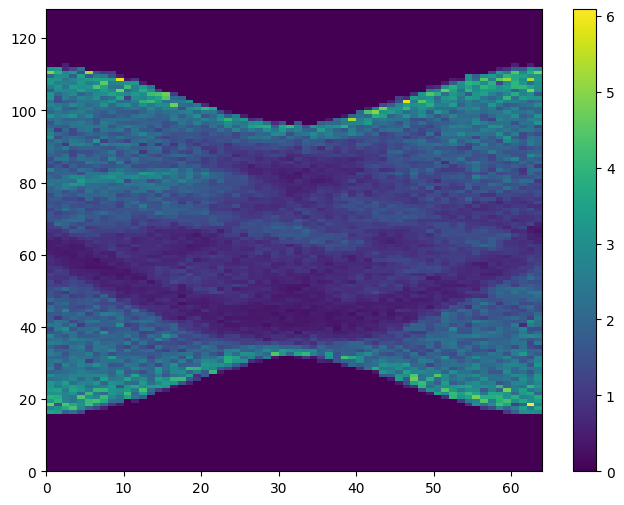

In [10]:
plt.figure(figsize=(8,6))
plt.pcolormesh(image_primary[1,1])
plt.colorbar()

# Testing PyTomography Reconstruciton

In [11]:
import os
import sys
import numpy as np
sys.path.append('/home/gpuvmadm/PyTomography/src')
import pytomography
from pytomography.metadata import PSFMeta
from pytomography.utils import pad_object, pad_image, unpad_object, unpad_image, rotate_detector_z
from pytomography.metadata import ObjectMeta, ImageMeta
from pytomography.projections import SystemMatrix
from pytomography.algorithms import OSEMOSL
from pytomography.priors import RelativeDifferencePrior
from pytomography.transforms import PETAttenuationTransform, PETPSFTransform
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from matplotlib import colors
import torch
from scipy.ndimage import map_coordinates
from scipy.interpolate import interpn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytomography.device = device

/tmp/ipykernel_5456/426782312.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [12]:
projections_primary = torch.tensor(np.transpose(np.stack([image_primary[0,0], image_primary[1,1], image_primary[2,2]]), (2,1,0))).unsqueeze(dim=0)
projections_scatter = torch.tensor(np.transpose(np.stack([image_scatter[0,0], image_scatter[1,1], image_scatter[2,2]]), (2,1,0))).unsqueeze(dim=0)
projections_tot = torch.tensor(np.transpose(np.stack([image_tot[0,0], image_tot[1,1], image_tot[2,2]]), (2,1,0))).unsqueeze(dim=0)

In [15]:
zCTo = np.linspace(-22,22,12)
xCTo = np.arange(128)
yCTo = np.arange(128)
zCTf = np.array([5,5.5,6])
m = np.meshgrid(zCTf, yCTo, xCTo, indexing='ij')
CT = np.fromfile(f'{result_dir}/groundtruth.attimg', dtype=np.float32)
CT = CT.reshape((12,128,128))
CT = map_coordinates(CT, m, order=1)
GT = map_coordinates(activity_distribution, m, order=1)
CT = torch.tensor(np.transpose(CT, (2,1,0)).copy()).unsqueeze(dim=0).to(device)
GT = torch.tensor(np.transpose(GT, (2,1,0)).copy()).unsqueeze(dim=0).to(device)

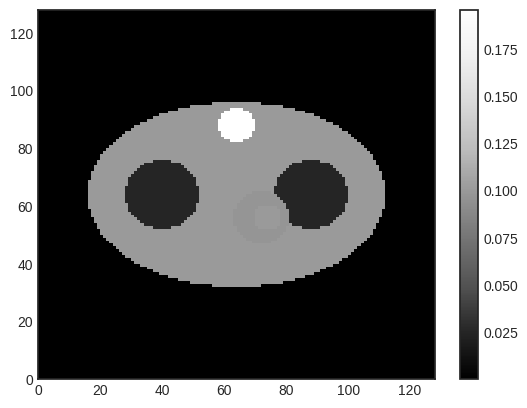

In [16]:
plt.pcolormesh(CT[0,:,:,1].cpu().numpy().T, cmap='Greys_r')
plt.colorbar()

In [17]:
object_meta = ObjectMeta(dr=(0.5,0.5,2), shape=[128,128,3])
image_meta = ImageMeta(object_meta, angles=np.linspace(0,180,64, endpoint=False))

In [20]:
ctnet = PETAttenuationTransform(CT = CT)
H = SystemMatrix(
    obj2obj_transforms=[],
    im2im_transforms=[ctnet],
    object_meta=object_meta,
    image_meta=image_meta)

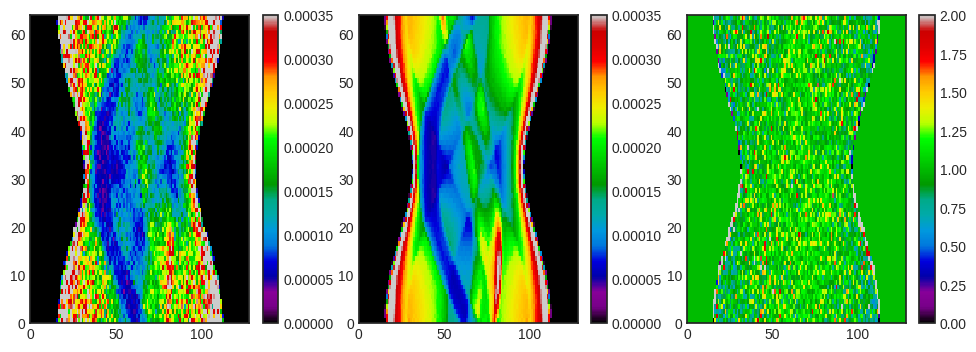

In [21]:
theo_sino = H.forward(GT)[0,:,:,0].cpu().numpy(); theo_sino = theo_sino/np.sum(theo_sino)
meas_sino = projections_primary[0,:,:,0].cpu().numpy(); meas_sino = meas_sino/np.sum(meas_sino)
plt.subplots(1,3, figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(meas_sino, cmap='nipy_spectral', vmin=0, vmax=0.00035)
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(theo_sino, cmap='nipy_spectral', vmin=0, vmax=0.00035)
plt.colorbar()
plt.subplot(133)
delta = 1e-8
plt.pcolormesh((theo_sino+delta)/(meas_sino+delta), cmap='nipy_spectral', vmin=0, vmax=2)
plt.colorbar()

Try to reconstruct object

In [22]:
initial_guess = torch.ones(object_meta.shape).unsqueeze(dim=0)
initial_guess.shape

torch.Size([1, 128, 128, 3])

In [24]:
prior = RelativeDifferencePrior(beta=0.05, gamma=5)

In [28]:
osem_net = OSEMOSL(image = projections_tot,
                   object_initial=initial_guess,
                   system_matrix=H,
                   prior=prior,
                   scatter=projections_scatter)
reconstructed_object_tot = osem_net(n_iters=50, n_subsets=8)

Text(0.5, 1.0, 'Predicted Counts (Primary+Scatter)')

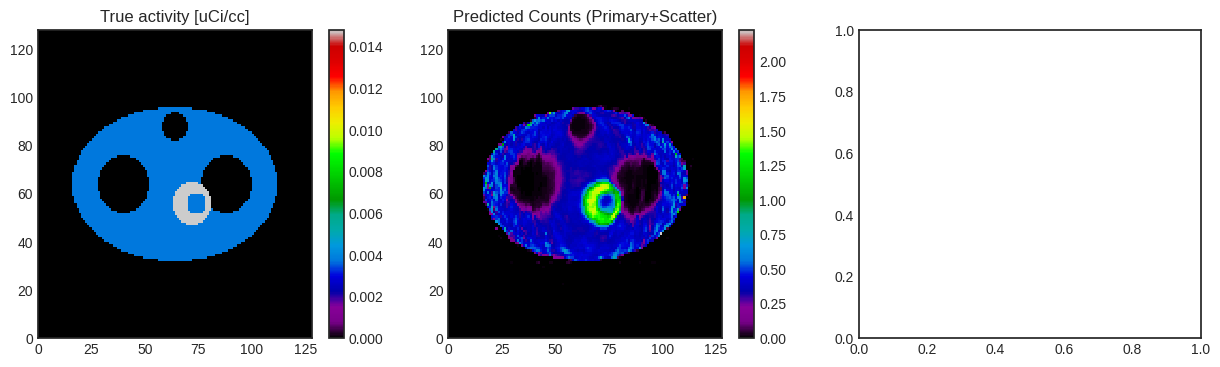

In [29]:
plt.subplots(1,3, figsize=(15,4))
plt.subplot(131)
plt.pcolormesh(GT[0,:,:,1].cpu().numpy().T, cmap='nipy_spectral')
plt.colorbar()
plt.title('True activity [uCi/cc]')
plt.subplot(132)
plt.pcolormesh(reconstructed_object_tot[0,:,:,1].cpu().numpy().T, 
cmap='nipy_spectral')
plt.colorbar()
plt.title('Predicted Counts (Primary+Scatter)')

# OTHER STUFF (IGNORE)

In [24]:
def kernel_noncol(x,r,R, delta=1e-8):
    if r**2<R**2:
        sigma = torch.sqrt(R**2 - r**2)/4 * np.pi / 180
    else:
        sigma = torch.zeros(r.shape) + delta
    result = torch.exp(-x**2/sigma**2 / 2)
    return result / (torch.sum(result)+delta)

def kernel_penetration(x,r,R,mu=0.87, delta=1e-8):
    result = torch.exp(-torch.abs(mu*x / ((r/R)*torch.sqrt(1-(r/R)**2) + delta)))
    if r>=0:
        result*= x <= 0
    else:
        result*= x >= 0
    return result / (torch.sum(result)+delta)

def kernel_scattering(x,r,R,scatter_fact=0.327):
    sigma = scatter_fact * torch.sqrt(1-(r/R)**2) / (2 * np.sqrt(2*np.log(2))) # fwhm -> sigma
    result = torch.exp(-x**2/sigma**2 / 2)
    return result / (torch.sum(result)+delta)

In [25]:
kernels = [kernel_noncol, kernel_penetration, lambda x, r, R: kernel_penetration(2*x, r, R), kernel_scattering]

Pretend the spacing is less than it is (smaller scanner)

In [26]:
dx = 0.6
object_meta = ObjectMeta(dr=(dx,dx,2), shape=[128,128,3])
image_meta = ImageMeta(object_meta, angles=np.linspace(0,180,256, endpoint=False), radii=40*np.ones(64))

In [27]:
ctnet = PETAttenuationNet(CT = CT, device=device)
psfnet = PETPSFNet(kernels, device=device)
fp_net = ForwardProjectionNet(obj2obj_nets=[],
                              im2im_nets=[ctnet,psfnet],
                              object_meta=object_meta,
                              image_meta=image_meta,
                              device=device)
bp_net = BackProjectionNet(obj2obj_nets=[],
                           im2im_nets=[ctnet,psfnet],
                           object_meta=object_meta,
                           image_meta=image_meta,
                           device=device)

/data/anaconda/envs/torch/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [28]:
psfnet.initialize_network(object_meta, image_meta)

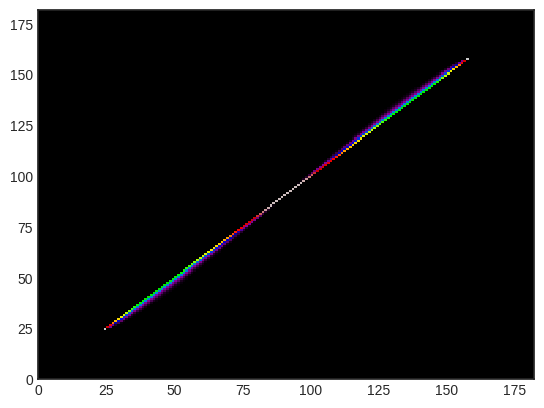

In [29]:
plt.pcolormesh(psfnet.PSF_matrix.cpu()[0][0][0], cmap='nipy_spectral')

In [30]:
projections_analytic = fp_net(torch.poisson(GT*4e7))

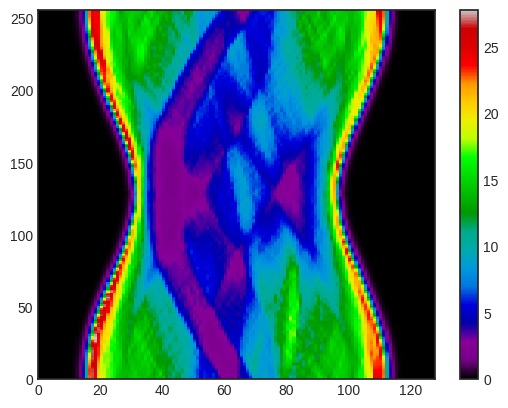

In [31]:
theo_sino = projections_analytic[0,:,:,0].cpu().numpy()
plt.pcolormesh(theo_sino, cmap='nipy_spectral')
plt.colorbar()


Can we reconstruct and adjust for blurring?

In [32]:
fp_netbad = ForwardProjectionNet(obj2obj_nets=[],
                              im2im_nets=[ctnet],
                              object_meta=object_meta,
                              image_meta=image_meta)
bp_netbad = BackProjectionNet(obj2obj_nets=[],
                           im2im_nets=[ctnet],
                           object_meta=object_meta,
                           image_meta=image_meta)

In [33]:
osem_net = OSEMOSL(image = projections_analytic,
                   object_initial=initial_guess,
                   forward_projection_net=fp_net,
                   back_projection_net=bp_net,)
reconstructed_object_analytic = osem_net(n_iters=20, n_subsets=8)

In [34]:
osem_netbad = OSEMOSL(image = projections_analytic,
                   object_initial=initial_guess,
                   forward_projection_net=fp_netbad,
                   back_projection_net=bp_netbad,)
reconstructed_object_analytic_bad = osem_netbad(n_iters=20, n_subsets=8)

In [35]:
imcorr = GT[0,:,:,1].cpu().numpy().T * 4e7
imgood = reconstructed_object_analytic[0,:,:,1].cpu().numpy().T
imbad = reconstructed_object_analytic_bad[0,:,:,1].cpu().numpy().T

Text(0.5, 1.0, 'Incorrect')

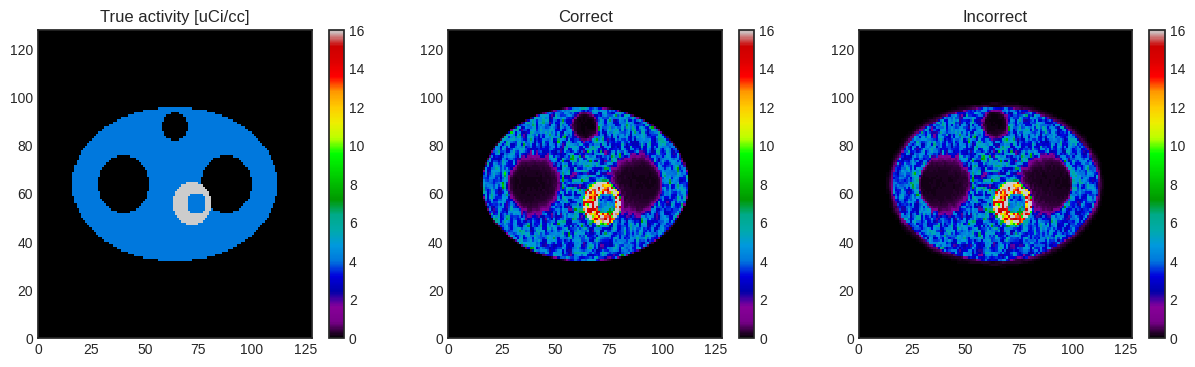

In [36]:
plt.subplots(1,3, figsize=(15,4))
plt.subplot(131)
plt.pcolormesh(imcorr, cmap='nipy_spectral')
plt.colorbar()
plt.title('True activity [uCi/cc]')
plt.subplot(132)
plt.pcolormesh(imgood, cmap='nipy_spectral', vmax=16)
plt.colorbar()
plt.title('Correct')
plt.subplot(133)
plt.pcolormesh(imbad, cmap='nipy_spectral', vmax=16)
plt.colorbar()
plt.title('Incorrect')

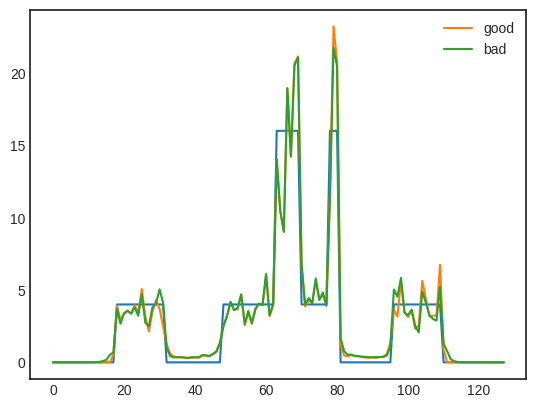

In [37]:
plt.plot(imcorr[55])
plt.plot(imgood[55], label='good')
plt.plot(imbad[55], label='bad')
plt.legend()